# VB01 - Variational Bayes

# Approximate a simple univariate pdf  

## Code by Joao Pedro Neto [Markdown tutorials](http://www.di.fc.ul.pt/~jpn/r/variational_inference/variational.html)

We have an intractable posterior distribution $ p(x|D)$ that we wish to approximate with $q(x)$, chosen from a given family of tractable distribution (eg, a gaussian).

We define $\widetilde{p}(x) = p(x|D)\cdot p(D) = p(x,D)$, which is easier to compute pointwise, since we don't need to compute the expensive $p(D)$.

The goal is to find an approximate $q$, where the cost function is defined as the KL-divergence from Information Theory:

$$J(q) = \KL{q}{\widetilde{p}} = \sum_{x} q(x) \log \frac{q(x)}{\widetilde{p}(x)}.$$

### Implement KL divergence in R

We can use this function to numericlly compute the KL divergence

In [1]:
# KL for continuous functions
KL <- function(q, p_tilde, lower, upper, ...) {
  f <- function(x) q(x, ...) * log(q(x, ...)/p_tilde(x))
  integrate(f, lower, upper)$value
}

### Example

Approximate $ \widetilde{p}\sim\gammadist(\alpha,beta)$ with each of two possible candidates:

- With $q_{1}\sim\lognormaldist(0,a_{1})$
- With $q_{2}\sim\lognormaldist(0,a_{2})$

In [2]:
alpha<-3.0
beta<-0.25
a1<-1.00
a2<-0.45
p_tilde <- function(x) dgamma(x, shape=alpha, scale=beta)
q1 <- function(x) dlnorm(x, 0,a1)
q2 <- function(x) dlnorm(x, 0,a2) 

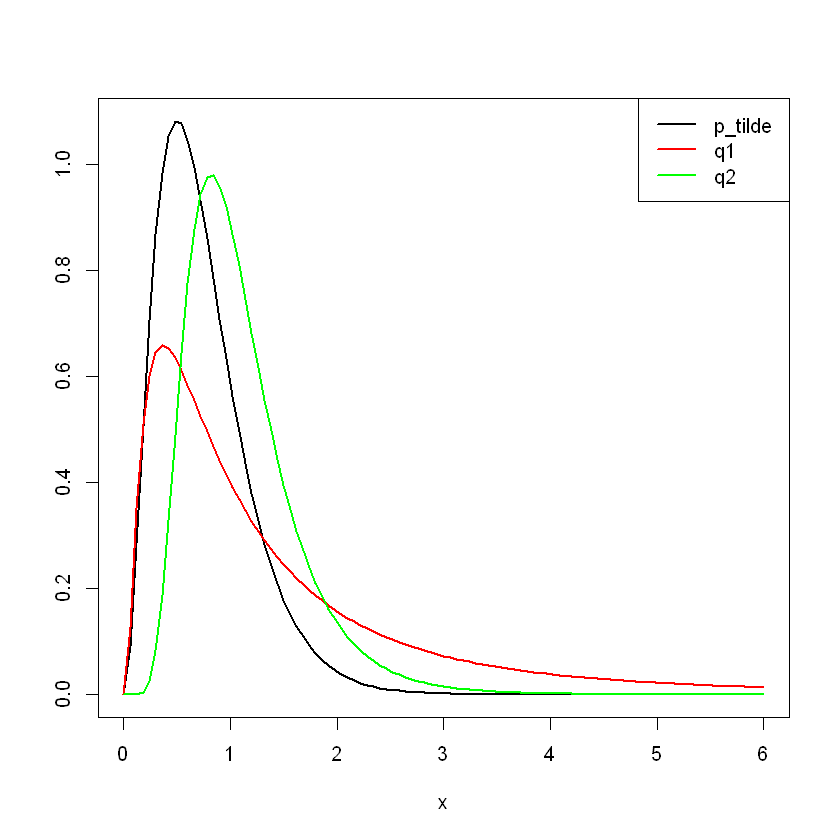

In [3]:
options(repr.plot.width=7, repr.plot.height=7)
curve(p_tilde, 0, 6, lwd=2, ylab="")
curve(q1,      0, 6, lwd=2, col="red",   add=T)
curve(q2,      0, 6, lwd=2, col="green", add=T)  # this one 'seems' closer...
legend("topright",c("p_tilde","q1","q2"),lwd=2,col=c("black","red","green"))

$q_2$ is much closer to the target density than $q_2$ and this is quantified by the KL divergence.

In [4]:
KL(q1,p_tilde, lower=1e-3, upper=100)
KL(q2,p_tilde, lower=1e-3, upper=100) # ...and in fact, KL gives a smaller number

[1] 1.709245

[1] 0.3400462

Notice that this is not exactly a KL divergence, since $ \widetilde{p}$ is a non-normalized 'distribution'.

To see that cost function $J$ works as desired, let's develop the equation:

$$
\begin{array}{lcll}
J(q)  & = & \sum_{x}q(x)\cdot\log\dfrac{q(x)}{\widetilde{p}(x)} &\\[0.2cm]
      & = & \sum_{x}q(x)\cdot\log\dfrac{q(x)}{p(x|D)p(D)}       &\\[0.2cm]
      & = & \sum_{x}q(x)\cdot\left(\log\dfrac{q(x)}{p(x|D)} - \log p(D) \right) &\\[0.2cm]
      & = & \sum_{x}q(x)\cdot\log\dfrac{q(x)}{p(x|D)} - \log p(D) &\mskip40mu \color{blue}{\sum_{x} q(x) = 1}\\[0.2cm]
      & = & \KL{q}{p(x|D)}-\log p(D) &
\end{array}
$$

Since $p(D)$ is a constant, it means that minimizing $J(q)$ is minimizing $\KL{q}{p(x|D)}$, and so $q(x)$ will approach $p(x|D)$.

## Aproximation via `optim`

Here's an example where we want to approximate a **Gamma target using log-normals:**

In [5]:
variational_lnorm <- function(p_tilde, lower, upper){
  q <- dlnorm # in this eg, q is a log-normal

    J <- function(params){
        KL(q, p_tilde,lower=lower,upper=upper,meanlog=params[1], sdlog=params[2])
        }

    optim(par=c(0, 1),fn=J)$par
    }

Target pdf

In [6]:
alpha<-3.0
beta<-0.25
p_tilde <- function(x) dgamma(x, shape=alpha, scale=beta)

Locate the minimum

In [7]:
approximation_params <- variational_lnorm(p_tilde, lower=1e-3, upper=100)
# get the resulting approximation:
q <- function(x) dlnorm(x, approximation_params[1], approximation_params[2])

Minimum value of $ KL$ found

In [8]:
KL(q,p_tilde,1e-3,10) # compute their "distance"

[1] 0.02765858

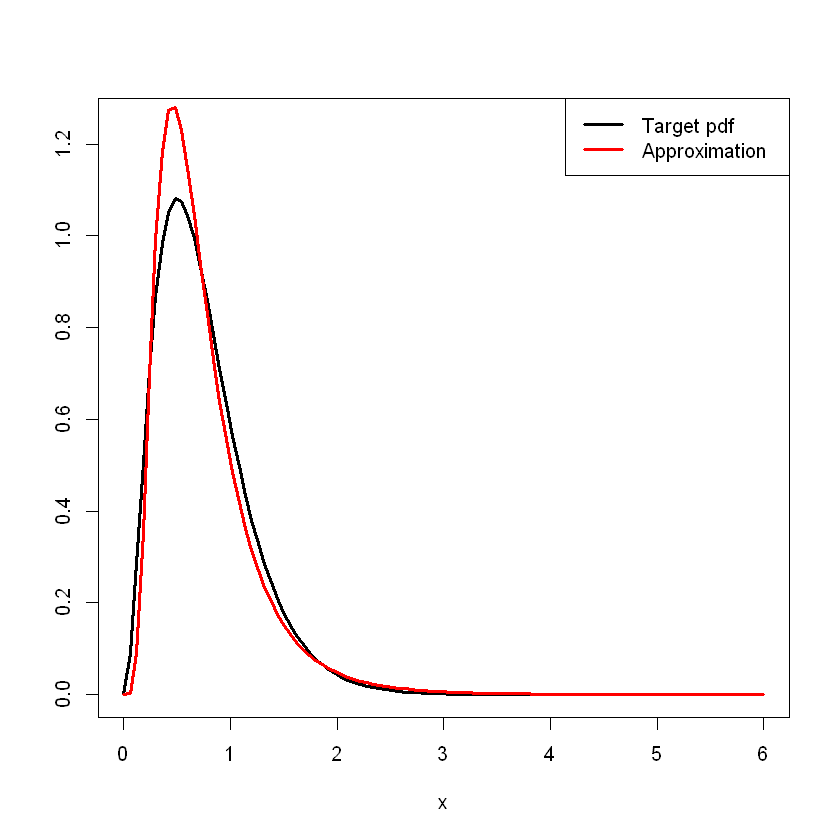

In [9]:
options(repr.plot.width=7, repr.plot.height=7)
curve(p_tilde, 0, 6, lwd=3, ylab="", ylim=c(0,1.25))
curve(q,       0, 6, lwd=3, col="red",   add=TRUE)
legend("topright",legend=c("Target pdf","Approximation"),lwd=3,col=c("black","red"))

Laplace approximation (ie, gaussian approximation) of a **Beta target with a Normal,**
(obtained via the variational method)

In [10]:
variational_norm <- function(p_tilde, lower, upper) {
  q <- dnorm  # in this eg, q is a normal

  J <- function(params) {
    KL(q, p_tilde, lower=lower, upper=upper, mean=params[1], sd=params[2])
  }

  optim(par=c(0.5, 0.2), fn=J)$par  # initial values are tricky, not very stable
}

Target pdf

In [11]:
p_tilde <- function(x) dbeta(x,11,9) # some given Beta distribution

In [12]:
approximation_params <- variational_norm(p_tilde, lower=1e-3, upper=1-1e-3)
# get the resulting approximation:
q <- function(x) dnorm(x, mean=approximation_params[1], sd=approximation_params[2])

KL(q,p_tilde,0,1) # compute their distance

[1] 0.004112233

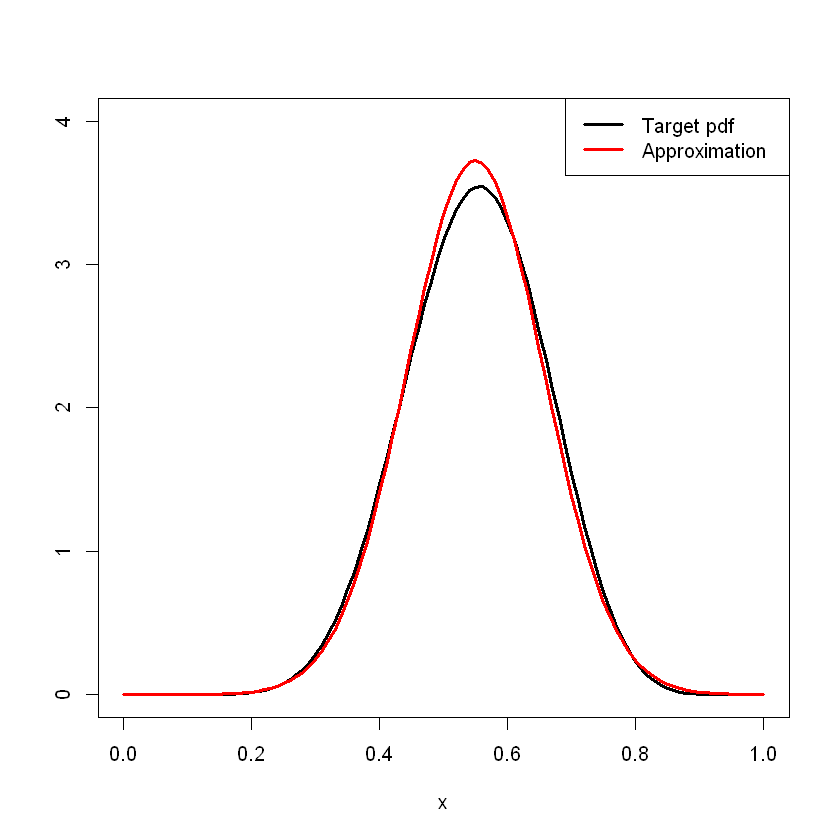

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
curve(p_tilde, 0, 1, lwd=3, col="black",ylab="", ylim=c(0,4))
curve(q,       0, 1, lwd=3, col="red",add=TRUE)
legend("topright",legend=c("Target pdf","Approximation"),lwd=3,col=c("black","red"))

The next example approximates a beta distribution with the [**Kumaraswamy distribution,**](https://en.wikipedia.org/wiki/Kumaraswamy_distribution) which has simpler PDF function

$$
    f_\text{kumar}(x|a,b) = abx^{a-1}(1-x^a)^{b-1}
$$

and has a closed CDF expression:

$$
    F_\text{kumar}(x|a,b) = 1-(1-x^a)^b
$$

In this [post](https://www.johndcook.com/blog/2009/11/24/kumaraswamy-distribution/), John Cook refers that, since the CDF is easy to invert, it's simple to generate random samples from $K(a,b)$ by generating $u \sim U(0,1)$ and return

$$
    F^{-1} = (1-(1-u)^{1/b})^{1/a}
$$

In [14]:
#install.packages("extraDistr", repos= "https://cloud.r-project.org")
require(extraDistr,quietly=TRUE)

Simulate $ n$ samples from the $f_\text{kumar}(x|a,b)$ pdf by the inverse cdf method

In [15]:
n <- 1e4
u <- runif(n)

a <- 1/2
b <- 1/2

ku <- (1 - (1-u)^(1/b))^(1/a)

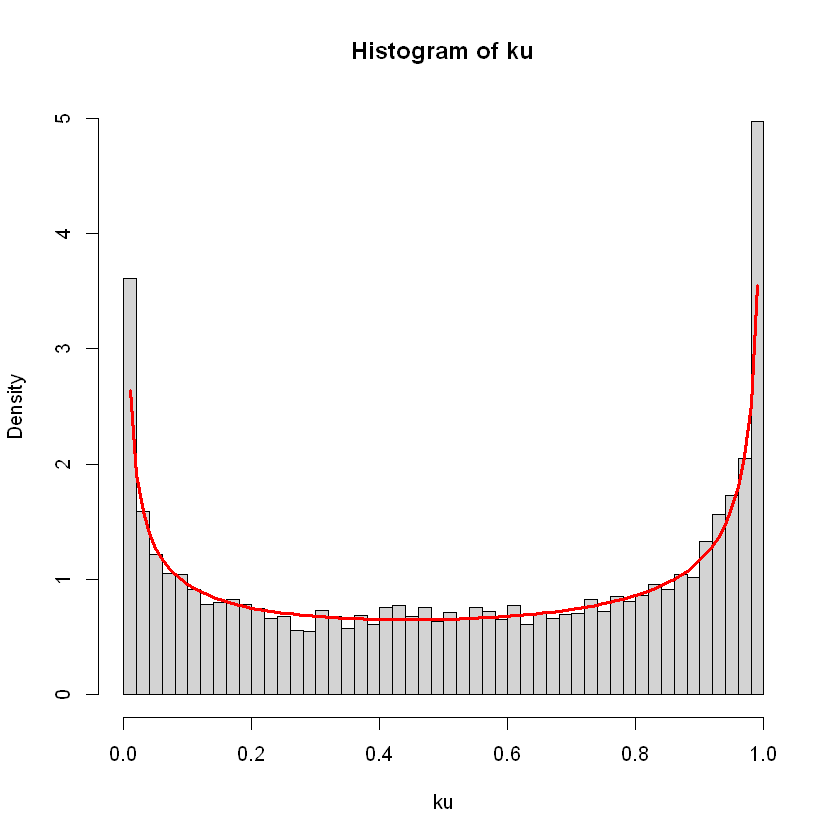

In [16]:
options(repr.plot.width=7, repr.plot.height=7)
hist(ku, breaks=50, prob=TRUE)
q <- function(x) dkumar(x,a,b)
curve(q, 0, 1, lwd=3, col="red", add=TRUE)

Variational approximation of a **Beta(1/2,1/2) target pdf with a Kumaraswamy**

In [17]:
variational_kumaraswamy <- function(p_tilde, lower, upper) {
  q <- dkumar

  J <- function(params) {
    # TODO: somehow the KL-divergence function outputs negative values (?)
    # included abs() in order to work
    abs(KL(q, p_tilde, lower=lower, upper=upper, a=params[1], b=params[2]))
  }

  optim(par=c(0.5, 0.5), fn=J, method="BFGS")$par
}

p_tilde <- function(x) dbeta(x,1/2,1/2)

approximation_params <- variational_kumaraswamy(p_tilde, lower=0.01, upper=0.99)

In [18]:
str(approximation_params)

 num [1:2] 0.479 0.483


In [19]:
# get the resulting approximation:
q <- function(x) dkumar(x, approximation_params[1], approximation_params[2])

In [20]:
KL(q,p_tilde,0.01,0.99) # compute their KL "distance"

[1] 1.240327e-16

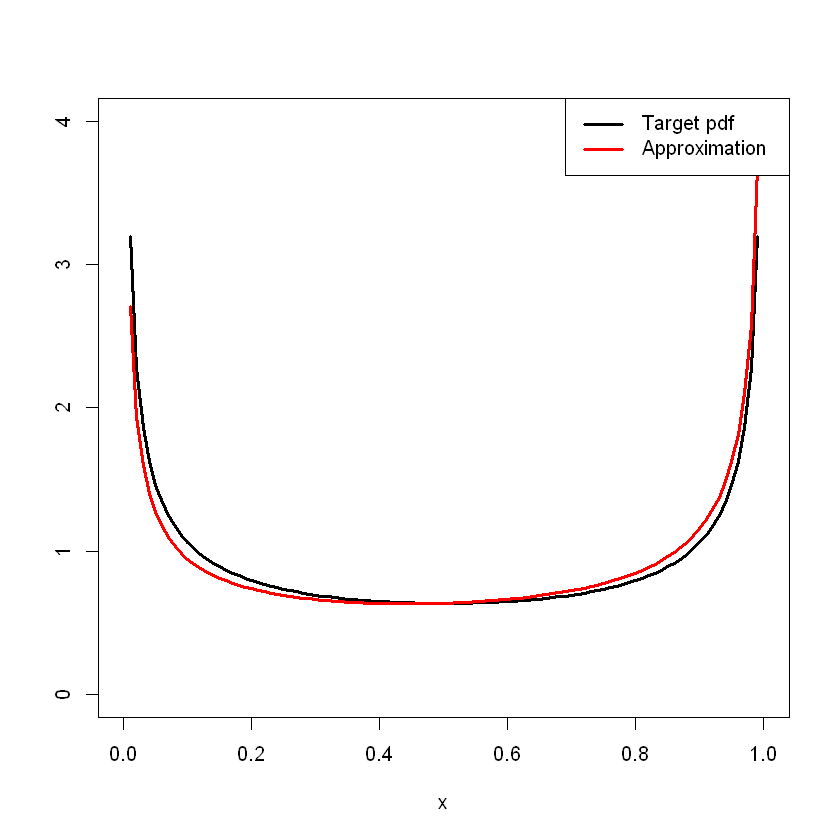

In [21]:
options(repr.plot.width=7, repr.plot.height=7)
curve(p_tilde, 0, 1, lwd=3, col="black",ylab="", ylim=c(0,4))
curve(q,       0, 1, lwd=3, col="red",   add=TRUE)
legend("topright",legend=c("Target pdf","Approximation"),lwd=3,col=c("black","red"))

Another example

Variational approximation of a **Beta(3,3) target pdf with a Kumaraswamy**

In [22]:
p_tilde <- function(x) dbeta(x,3,3)

In [23]:
approximation_params <- variational_kumaraswamy(p_tilde, lower=0.01, upper=0.99)
# get the resulting approximation:
q <- function(x) dkumar(x, approximation_params[1], approximation_params[2])

In [24]:
#q <- function(x) dkumar(x, 5, 251/40)

KL(q,p_tilde,0.01,0.99) # compute their distance

[1] 0.001386222

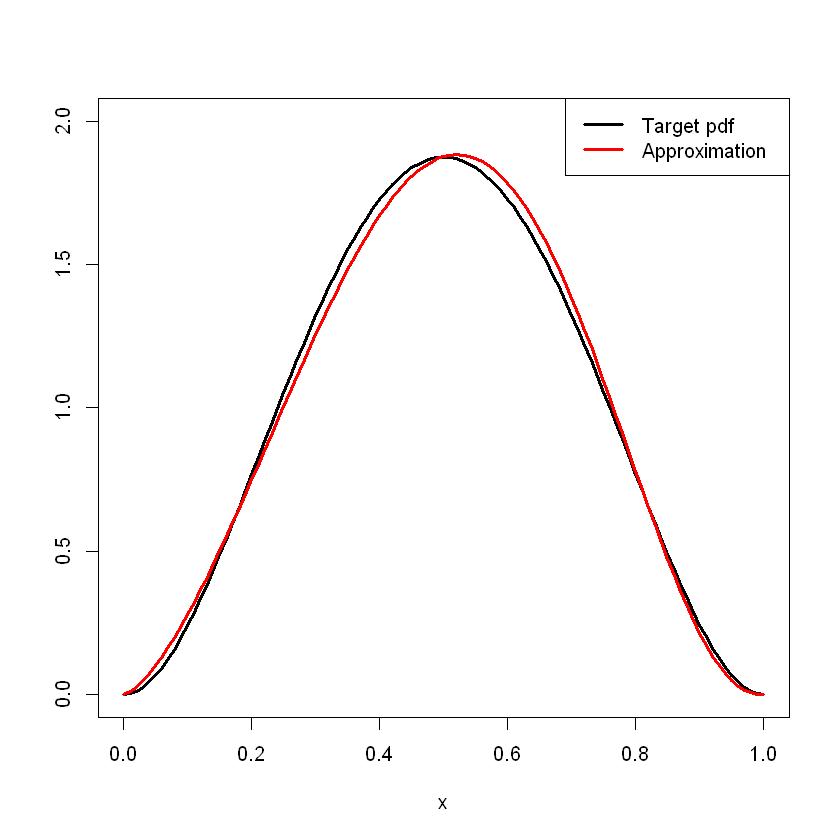

In [25]:
options(repr.plot.width=7, repr.plot.height=7)
curve(p_tilde, 0, 1, lwd=3,col="black",ylab="", ylim=c(0,2.0))
curve(q,       0, 1, lwd=3,col="red", add=TRUE)
legend("topright",legend=c("Target pdf","Approximation"),lwd=3,col=c("black","red"))

But this method, for these two distributions, is very unstable. It diverges with many parameter values...